In [58]:
import torch as t
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

##torchvision提供数据库借口
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show=ToPILImage() #Tensor转化成Image 方便可视化


In [59]:
##自动下载CIFAR10约100MB

#数据预处理
transform=transforms.Compose([transforms.ToTensor(),#转为Tensor
                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),#归一化
                             ])
#训练集
trainset=tv.datasets.CIFAR10(
                root='/home/saber/dev/Fate/Berserker/CIFAR',
                train=True,
                download=True,
                transform=transform)

trainloader=t.utils.data.DataLoader(
                trainset,
                batch_size=4,
                shuffle=True,
                num_workers=2
)

#测试集
testset=tv.datasets.CIFAR10(
                root='/home/saber/dev/Fate/Berserker/CIFAR',
                train=True,
                download=True,
                transform=transform)

testloader=t.utils.data.DataLoader(
                testset,
                batch_size=4,
                shuffle=True,
                num_workers=2
)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


ship
8


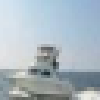

In [60]:
(data,label)=trainset[100]
# transforms.ToTensor()
print(classes[label])
print(label)
# (data+1)/2还原被归一化数据
show((data+1)/2).resize((100,100))
# trainset[100]
# t.FloatTensor(trainset[100])

       frog      horse      horse       frog


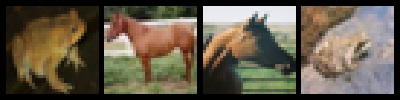

In [61]:
dataiter=iter(trainloader)
images,labels=dataiter.next() #返回4张图片与标签
print(''.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

In [62]:
class Net(nn.Module):
    def __init__(self):
        #nn.module子类函数必须在构造函数中执行父类的构造函数
        super(Net,self).__init__()
        ##等价于 nn.moduel.__init__()
        ##卷积层3:CIFAR3通道 6:输出6通道 5:卷积核5*5
        self.conv1=nn.Conv2d(3,6,5)
        self.conv2=nn.Conv2d(6,16,5)
        #fc层 y=wx+b
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        #卷积--激活--池化
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        #reshape -1:自适应
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

net=Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [63]:
##定义损失函数与优化器
criterion=nn.CrossEntropyLoss() #交叉熵损失函数
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [72]:
for epoch in range(2):
    running_loss=0.0
    for i,data in enumerate(trainloader,0):
        
        #输入数据
        inputs,labels=data
        inputs,labels=Variable(inputs),Variable(labels)
        
        #梯度清零
        optimizer.zero_grad()
        
        #forward & backward
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        
        #更新参数
        optimizer.step()
        
        #打印log信息
#         t.tensor.item(loss.data)
        running_loss+=loss.data
        if i %2000 == 1999:  #每2000个batch打印一次训练状态
            print('[%d,%5d] loss: %.3f'\
                 %(epoch+1,i+1,running_loss/2000))
            running_loss=0.0
    print('Finished Training')

[1, 2000] loss: 1.214
[1, 4000] loss: 1.220
[1, 6000] loss: 1.207
[1, 8000] loss: 1.220
[1,10000] loss: 1.190
[1,12000] loss: 1.186
Finished Training
[2, 2000] loss: 1.130
[2, 4000] loss: 1.111
[2, 6000] loss: 1.124
[2, 8000] loss: 1.124
[2,10000] loss: 1.121
[2,12000] loss: 1.099
Finished Training


实际的label:     deer--     cat--    ship--     dog


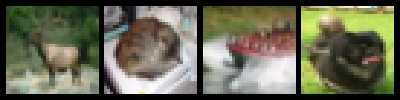

In [83]:
dataiter=iter(testloader)
images,labels=dataiter.next()#每batch返回4张图片
#join连接字符串
print('实际的label:','--'.join(\
                        '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images/2-0.5)).resize((400,100))

In [87]:
##测试网络预测结果
outputs=net(Variable(images))
#得分最高的类别
_,predicted=t.max(outputs.data,1)

print('预测分类结果',''.join('%5s'\
                      % classes[predicted[j]] for j in range(4)))

预测分类结果  bird deer ship ship


In [90]:
##查看整个测试集上的效果

correct=0 #预测正确的图片数
total=0 #总共的图片数
for data in testloader:
    images,labels=data
    outputs=net(Variable(images))
    _,predicted=t.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum()
    
print('10000张测试集中准确率为: %d %%' %(100*correct/total))

10000张测试集中准确率为: 64 %


In [92]:
##GPU上加速训练 复杂网络大数据量才可以看出来
if t.cuda.is_available():
    net.cuda()
    images=images.cuda()
    labels=labels.cuda()
    outputs=net(Variable(images))
    loss=criterion(outputs,Variable(labels))